In [15]:
### import necessary packages
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

In [25]:
### transforms a root file in a single index file
### had issues reading out the multiindex file although I think this is the way to go for an optimized script
### the function also sorts in zp for the further analysis
def transform_root_file_and_sort_by_z(filename):
    events=uproot.open(filename)["events"]
    events2=events["events"]# why do I have to do that
    df =  events2.pandas.df(["ed", "zp","xp","yp","trackid","parentid","etot"]) # make a pandas data frame with the parameters of interest
    df2 = df.sort_values('zp', ascending=False).sort_index(level='entry', sort_remaining=False) # sort by z
    df3 = df2.reset_index(level="entry") # remove multiindex1
    df4 = df3.reset_index(level="subentry") # remove multiindex2
    return df4

In [26]:
### this is most likely outdated and was a solution where I included the first and last index in separate cases.

def get_data_frame_with_summed_energy_complicated(df4,z_res):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    for j in df4.index:
    #tqdm(df4.index):#len(df2.groupby(level=0))):
        #print(df4["zp"][j])
        #print(energy_in_one,j,df4["zp"][j],"start",df4["ed"][j])
        #print(np.abs(df4["zp"][j+1]-df4["zp"][j]),"diff_high")
        #print(np.abs(df4["zp"][j-1]-df4["zp"][j]),"diff_low")       
            if(j==0): # first index
                if((np.abs(df4.at[j+1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j+1,"entry"] ): # check whether two subsequent indices are within the same z
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"1")
                    energy_in_one+=df4.at[j,"ed"] # if so, add it to summed energy
            elif(j>0 and j<(len(df4)) and (np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j-1,"entry"]):    
                    energy_in_one+=df4.at[j,"ed"]
                    #print(df4["zp"][j],(np.abs(df4["zp"][j-1]-df4["zp"][j])),"3")  
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"])
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            elif(j==(len(df4))): # last index (not working properly)
                if((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and df4.at[j,"entry"]==df4.at[j-1,"entry"]):
                    energy_in_one+=df4.at[j,"ed"]
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"2")
            else:   # if resolveable, write out the energy summed so far                    
                    #print(df4["zp"],(np.abs(df4["zp"][j-1]-df4["zp"][j])),"4")
                    #print((np.abs(df4["zp"][j+1]-df4["zp"][j])),"5")
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"])
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"]   

    df_new = pd.DataFrame()
    df_new["event_id"] = event_list
    df_new["energy"] = energy_list
    df_new["etot"] = energy_tot_list
    return df_new
    


In [27]:
### function to obtain summed energy using z resolution only
### the code scans trough the data frame and adds up energy values until it is resolvable in z
### code is added to a list and put back in a df 

### toDO: there is a lot of ways to improve the efficience (benchmark at the moment on my machine 5min for 100k, 45min for 1M events)
### toDO: check a bit more carefully what happens on transitions between events and for the last and first case

def get_data_frame_with_summed_energy(df4,z_res): #pick a resolution in z and a data frame
    energy_in_one = 0 # initialize the variable to add energy if below z_res
    energy_list = [] # lists for later
    event_list = []
    energy_tot_list = []
    for j in df4.index:
    #tqdm(df4.index):#len(df2.groupby(level=0))):
      if(j>0 and j<(len(df4))): #ignore last and first event since it is annoying when doing +-1
            if((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"]))<z_res and (df4.at[j,"entry"]==df4.at[j-1,"entry"])): #if same event and below z_res add up   
                    energy_in_one+=df4.at[j,"ed"] 
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) : # if the event ends, add into the list the energy which is stored at the moment
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"]) # 
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"]) # j-1, since we are at a point where J is already from the next event
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"]      

    df_new = pd.DataFrame()
    df_new["event_id"] = event_list
    df_new["energy"] = energy_list
    df_new["etot"] = energy_tot_list
    return df_new
    


In [35]:
### in progress
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked


def get_data_frame_with_summed_energy_xy(df4,z_res,xy_res):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    for j in df4.index:
        if(j>0 and j<(len(df4))):
            if  (df4.at[j,"entry"]==df4.at[j-1,"entry"] 
            and ((np.abs(df4.at[j-1,"zp"]-df4.at[j,"zp"])<z_res))
            and ((np.abs(df4.at[j-1,"xp"]-df4.at[j,"xp"])<xy_res)) 
            and ((np.abs(df4.at[j-1,"yp"]-df4.at[j,"yp"])<xy_res))):
                            energy_in_one+=df4.at[j,"ed"]
            elif(df4.at[j,"entry"]!=df4.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j,"entry"])
                    energy_tot_list.append(df4.at[j,"etot"])
                    energy_in_one = df4.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(df4.at[j-1,"entry"])
                    energy_tot_list.append(df4.at[j-1,"etot"])
                    energy_in_one = df4.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
                
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [29]:
def get_number_of_scatter(df_new,number_of_events=10000,multiplicity=2): # number of events can be set by the length of your file (toDO: it may need a correction by 1), multiplicity is simply how many scatter you want
    scatter_list = [] # I love lists apparently
    fraction_above_multi = 0 # will be the final value for the fraction above a certain multiplicity
    for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id']):
        scatter_list.append(len(df_new[df_new['event_id'] == i]))
    ## list comprehension below, isn't faster
    #different_num = [len(df_new[df_new['event_id'] == i]) for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id'])]
    fraction_above_multi = np.divide(np.count_nonzero(np.asarray(scatter_list)>multiplicity),number_of_events) # just count all events above a certain multiplicity and calculate a ratio to the total events
    return fraction_above_multi

In [30]:
df4 = transform_root_file_and_sort_by_z("10ktest.root")

In [31]:
fraction_list = []
res_values = np.arange(10,50,10)
for i in res_values:
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy(df4,i)))
fraction_list    

[0.5013, 0.2433, 0.1147, 0.0583]

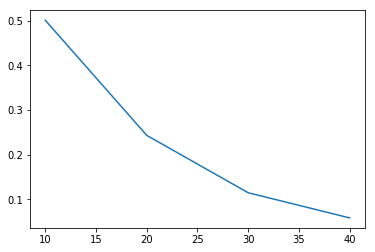

In [32]:
plt.plot(np.arange(10,50,10),fraction_list)

In [33]:
fraction_list = []
for i in np.arange(10,50,10):
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy(df4,i),number_of_events=10000,multiplicity=3))
f1 = fraction_list    

fraction_list = []
for i in np.arange(10,50,10):
    fraction_list.append(get_number_of_scatter(get_data_frame_with_summed_energy_xy(df4,i,50),number_of_events=10000,multiplicity=3))
f3 = fraction_list    

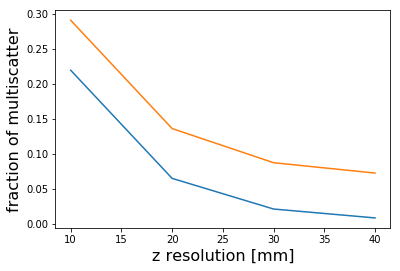

In [34]:
x = np.arange(10,50,10)
plt.plot(x,f1)
plt.plot(x,f3)
plt.xlabel("z resolution [mm]",fontsize="16")
plt.ylabel("fraction of multiscatter",fontsize="16")
plt.show()